In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import (build_vocab, get_context,
                                         get_unigram_counts, is_corpus_title,
                                         is_longer_text)
from torchlake.language_model.models import IVLBL, VLBL
from torchlake.language_model.models.vlbl.loss import NCE
from torchlake.language_model.controller.trainer_vlbl import VLBLTrainer, IVLBLTrainer
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import WikiText2, WikiText103

To utilize this notebook, you have to install `portalocker` first

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
DATASET_NAME = "WikiText2"

In [5]:
artifact_path = Path('../../artifacts/vlbl')
artifact_path.mkdir(exist_ok=True)

artifact_dataset_path = artifact_path.joinpath(DATASET_NAME)
artifact_dataset_path.mkdir(exist_ok=True)

data_path = Path('../../data') / DATASET_NAME

In [6]:
CONTEXT = NlpContext()

In [7]:
BATCH_SIZE = 32
CONTEXT_SIZE = 5

In [8]:
DEVICE = torch.device(CONTEXT.device)

In [9]:
tokenizer = get_tokenizer('basic_english')

In [10]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, context_size))
        .filter(lambda text: not is_corpus_title(text))
        .map(tokenizer)
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [11]:
train_datapipe, val_datapipe, test_datapipe = WikiText2(data_path.as_posix())

In [12]:
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
vocab = build_vocab(cloned_train_datapipe)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

20351

In [14]:
# write_json_file(
#     artifact_dataset_path.joinpath("vocab.json"),
#     list(vocab.get_stoi().keys()),
# )

In [15]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 'on',
 'as',
 's',
 'that',
 'for']

In [16]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.Truncate(CONTEXT.max_seq_len - 1),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [17]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [18]:
NUM_WORKERS = get_num_workers()

In [19]:
collate_fn = lambda data: get_context(
    data,
    CONTEXT_SIZE // 2,
    CONTEXT_SIZE // 2,
)

train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [20]:
# check context size
# for data in train_datapipe:
#     if len(data) < 5:
#         print(data)
#         break

In [21]:
# sample
# for data in train_datapipe:
#     if len(data) > 5:
#         print(data)
#         print(vocab.lookup_tokens(data))
#         break

In [22]:
# count = 0
# for data in train_datapipe:
#   count += len(data)
# count

In [23]:
# number of words in training corpurs
# wikitext2 count 1,993,228
# wikitext103 count 101,227,641

In [24]:
for gram, context in train_dataloader:
    print(gram.shape, context.shape)
    break

torch.Size([32, 1, 252]) torch.Size([32, 4, 252])


# Model

In [25]:
# 4s ~ 5s with wikitext2
# 3m50s ~ 4m30s with wikitext103
word_counts = get_unigram_counts(map(lambda x: x.tolist(), train_datapipe), VOCAB_SIZE)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [26]:
sum(word_counts)

tensor(4468736)

In [27]:
EMBED_DIM = 300

## vLBL

In [28]:
model = VLBL(VOCAB_SIZE, EMBED_DIM, CONTEXT_SIZE - 1, CONTEXT).to(DEVICE)

In [29]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
VLBL                                     20,351
├─Embedding: 1-1                         6,105,300
├─Embedding: 1-2                         6,105,300
├─Conv2d: 1-3                            5
Total params: 12,230,956
Trainable params: 12,230,956
Non-trainable params: 0

In [30]:
EPOCHS = 10

In [31]:
criterion = NCE(word_counts, context=CONTEXT)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
trainer = VLBLTrainer(EPOCHS, DEVICE)

In [33]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion)

546it [00:32, 17.02it/s]


epoch 1 : 3.582032930785423


546it [00:25, 21.01it/s]


epoch 2 : 0.17100193282874432


546it [00:26, 20.76it/s]


epoch 3 : 0.10823747167392786


546it [00:26, 20.99it/s]


epoch 4 : 0.10395571294792959


546it [00:24, 22.68it/s]


epoch 5 : 0.09961384366839222


546it [00:25, 21.83it/s]


epoch 6 : 0.09507215268206531


546it [00:24, 22.29it/s]


epoch 7 : 0.09014801874476819


546it [00:26, 20.74it/s]


epoch 8 : 0.08522602886910782


546it [00:26, 20.35it/s]


epoch 9 : 0.08021002863623428


546it [00:25, 21.17it/s]

epoch 10 : 0.07529873714383647


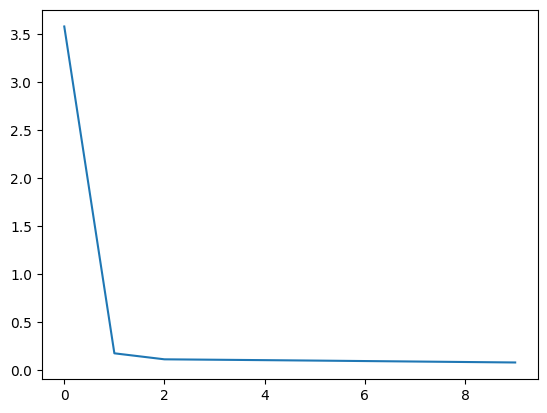

In [34]:
plt.plot(training_loss)

In [63]:
model_path = artifact_path / f"vlbl.{DATASET_NAME}.pth"

In [36]:
torch.save(model.state_dict(), model_path)

In [37]:
get_file_size(model_path)

'46.66MB'

In [64]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## ivLBL

In [50]:
model = IVLBL(VOCAB_SIZE, EMBED_DIM, CONTEXT_SIZE - 1, CONTEXT).to(DEVICE)

In [40]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
IVLBL                                    20,355
├─Embedding: 1-1                         6,105,300
├─Embedding: 1-2                         6,105,300
Total params: 12,230,955
Trainable params: 12,230,955
Non-trainable params: 0

In [51]:
EPOCHS = 10

In [52]:
criterion = NCE(word_counts, context=CONTEXT)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [53]:
trainer = IVLBLTrainer(EPOCHS, DEVICE)

In [54]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion)

546it [01:04,  8.41it/s]


epoch 1 : 6.0178211878244205


546it [01:02,  8.72it/s]


epoch 2 : 4.558639676717309


546it [00:58,  9.30it/s]


epoch 3 : 4.144979836632635


546it [01:00,  9.04it/s]


epoch 4 : 3.962585554551248


546it [01:00,  9.00it/s]


epoch 5 : 3.8444932147409805


546it [00:59,  9.18it/s]


epoch 6 : 3.752974166223262


546it [01:00,  9.06it/s]


epoch 7 : 3.6757413917020525


546it [01:01,  8.84it/s]


epoch 8 : 3.6073582268547946


546it [01:05,  8.36it/s]


epoch 9 : 3.545245304990536


546it [01:01,  8.89it/s]

epoch 10 : 3.487283074232988


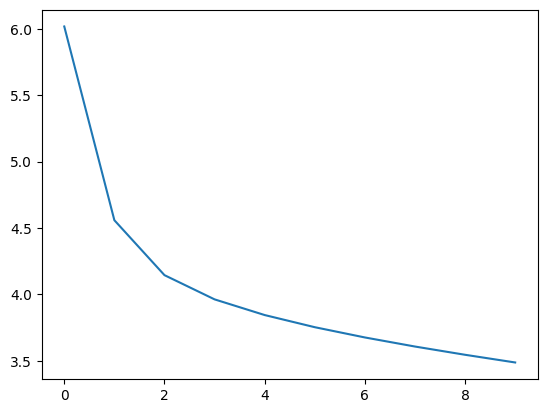

In [55]:
plt.plot(training_loss)

In [73]:
model_path = artifact_path / f"ivlbl.{DATASET_NAME}.pth"

In [47]:
torch.save(model.state_dict(), model_path)

In [48]:
get_file_size(model_path)

'46.66MB'

In [74]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Evaluation


## word analogy


In [56]:
from torchlake.language_model.datasets import WordAnalogyDataset 

In [57]:
analogy_data_path = Path('../../data') / "word-analogy"

In [65]:
dataset = WordAnalogyDataset(analogy_data_path)

In [66]:
dataset.data[:20]

[('Athens', 'Greece', 'Baghdad', 'Iraq'),
 ('Athens', 'Greece', 'Bangkok', 'Thailand'),
 ('Athens', 'Greece', 'Beijing', 'China'),
 ('Athens', 'Greece', 'Berlin', 'Germany'),
 ('Athens', 'Greece', 'Bern', 'Switzerland'),
 ('Athens', 'Greece', 'Cairo', 'Egypt'),
 ('Athens', 'Greece', 'Canberra', 'Australia'),
 ('Athens', 'Greece', 'Hanoi', 'Vietnam'),
 ('Athens', 'Greece', 'Havana', 'Cuba'),
 ('Athens', 'Greece', 'Helsinki', 'Finland'),
 ('Athens', 'Greece', 'Islamabad', 'Pakistan'),
 ('Athens', 'Greece', 'Kabul', 'Afghanistan'),
 ('Athens', 'Greece', 'London', 'England'),
 ('Athens', 'Greece', 'Madrid', 'Spain'),
 ('Athens', 'Greece', 'Moscow', 'Russia'),
 ('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden')]

In [67]:
tokens = [[vocab[word.lower()] for word in pairs] for pairs in dataset.data]
tokens[:10]

[[12958, 6970, 18304, 5313],
 [12958, 6970, 9016, 6480],
 [12958, 6970, 10275, 1346],
 [12958, 6970, 4686, 1270],
 [12958, 6970, 0, 4409],
 [12958, 6970, 14016, 2280],
 [12958, 6970, 16617, 481],
 [12958, 6970, 14322, 1572],
 [12958, 6970, 17076, 6546],
 [12958, 6970, 0, 6575]]

In [68]:
tokens = torch.LongTensor([token for token in tokens if len(token) == 4]).to(DEVICE)

In [69]:
# use word embed for vlbl
# use context embed for ivlbl
vectors = model.context_embed(tokens)

In [70]:
vectors.shape

torch.Size([19544, 4, 300])

In [71]:
# vlbl/word: 0.11, context: 0.8
# ivlbl/word: 0.16, context: 0.23
metric = nn.CosineSimilarity()

country_a, capital_a, country_b, capital_b = vectors.transpose(0, 1)
score = metric(country_a - capital_a - country_b, -capital_b)
print(score.mean().item())

0.228702113032341
